Reviewed: Jan 2024

This notebook may be run in Colab

To run this code on the GPU:

**Runtime -> Change runtime type -> GPU**

# **Fitting AlexNet to FashionMNIST data**



In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim   # SGD
import time
import numpy as np
from tqdm.autonotebook import tqdm   #adds a progress bar to track training

C:\Users\YT\AppData\Local\Temp\ipykernel_18032\4015534334.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm   #adds a progress bar to track training


In [2]:
#Check if GPU is available. The program will run using the GPU if available,
#otherwise will use CPU.
cuda = torch.cuda.is_available()
cuda #returns a Boolean indicating availability of GPU

True

## AlexNet using nn.Sequential

Documentation for nn modules used in `net`:
[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
[MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
[Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)



In [3]:
#AlexNet
model = nn.Sequential(
    # Here, we use a larger 11 x 11 window to capture objects. At the same
    # time, we use a stride of 4 to greatly reduce the height and width of the
    # output. Here, the number of output channels is much larger than that in
    # LeNet
    nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the number of
    # output channels
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of output
    # channels is further increased. Pooling layers are not used to reduce the
    # height and width of input after the first two convolutional layers
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # Output layer. Since we are using Fashion-MNIST, the number of classes is
    # 10, instead of 1000 as in the paper
    nn.Linear(4096, 10))

#**Test the model**
Feed in one mini-batch into the model

In [4]:
#Test the model by feeding in one mini-batch
# NCHW format
input = torch.randn((64,1,224,224))
output = model(input)
print(output.shape)

torch.Size([64, 10])


In [ ]:
#This is optional.
# Do not run this if you wish to use the default setting to initialise
# the parameters in nn.torch
def init_weights(m):
    "Initialise weights to the linear layer"
    if type(m) == nn.Linear:
        nn.init.normal_(tensor=m.weight, mean=0.0,std=0.01)
        #nn.init.zeros_(tensor=m.weight)
        #nn.init.zeros_(tensor=m.bias)
        #nn.init.ones_(tensor=m.weight)
        ##nn.init.xavier_normal_(tensor=m.weight)

model.apply(init_weights);

In [5]:
#Displays model parameters
print(list(model.parameters()))

[Parameter containing:
tensor([[[[ 0.0644, -0.0238, -0.0658,  ..., -0.0076,  0.0478,  0.0554],
          [-0.0059, -0.0350, -0.0519,  ...,  0.0267,  0.0528, -0.0302],
          [ 0.0782, -0.0734, -0.0145,  ..., -0.0744, -0.0545,  0.0800],
          ...,
          [ 0.0411,  0.0834,  0.0512,  ..., -0.0385, -0.0482,  0.0504],
          [-0.0670,  0.0892,  0.0781,  ..., -0.0837, -0.0730, -0.0751],
          [ 0.0465, -0.0100, -0.0895,  ..., -0.0870,  0.0354, -0.0439]]],


        [[[-0.0374,  0.0478,  0.0798,  ...,  0.0366, -0.0397, -0.0517],
          [-0.0824, -0.0356, -0.0338,  ...,  0.0169, -0.0055,  0.0757],
          [ 0.0266,  0.0198, -0.0845,  ..., -0.0759,  0.0202,  0.0190],
          ...,
          [ 0.0592,  0.0153,  0.0350,  ..., -0.0247,  0.0181,  0.0759],
          [-0.0270, -0.0706, -0.0845,  ..., -0.0140, -0.0745, -0.0531],
          [-0.0174, -0.0559,  0.0288,  ...,  0.0856,  0.0306, -0.0523]]],


        [[[ 0.0732, -0.0804,  0.0134,  ...,  0.0240, -0.0845, -0.0742],
   

In [6]:
#Set up device to do computation. Device is either cpu or gpu.
#Set device = gpu if gpu available
device = torch.device("cuda" if cuda else "cpu")

#Transfer model to device.
model.to(device)

Sequential(
  (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6400, out_features=4096, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=4096, out_features=4096, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_featu

# Resizing images

AlexNet takes in images of size 224 x 224. As the images in FashionMnist are 28 x 28 we resize them.

We will run out of RAM if we try to load all the resized data at once.
So we will write a function `get_data_loaders` that returns `bath_size` number of resized images.

In [7]:
def get_data_loaders(batch_size):
  """
  Loads FashionMNIST training data, converts to tensor, resizing the images from the original
  28 x 28 to 224 x 224 (required by the original AlexNet), and scales pixel intensities to [0,1].

  Split the training data into a sample used for training, and a validation set.

  Parameter:
              batch_size(int): mini-batch size

  Returns:

              train_loader(4d tensor- NCHW): mini-batch of batch_size of training data
              val_loader(4d tensor - NCHW): mini-batch of batch_size of validation data

  """
  resize = 224
  data_transform = transforms.Compose([ transforms.Resize(resize),
                                         transforms.ToTensor()])

  train_set = datasets.FashionMNIST('data',download=True, transform=data_transform,train=True)

  #------------Set up indices that splits the training set into training sample and validation sample----------#

  #proportion in validation set
  prop_val = 0.3
  #Set to small value for debug stage. Make multiple of batch_size
  sample_size = 3200
  #to use full training set range(len(fashion_mnist))
  indices = list(range(sample_size))
  #np.random.shuffle(indices)
  split = int(np.floor(prop_val*sample_size))
  #Now obtain the indices for train sample, and validation sample
  train_sample = SubsetRandomSampler(indices[split:])
  val_sample = SubsetRandomSampler(indices[:split])

  #Obtain the training and validation sets using the indices
  train_loader = DataLoader(train_set,sampler=train_sample,batch_size=batch_size)
  val_loader = DataLoader(train_set,sampler=val_sample,batch_size=batch_size)

  return train_loader, val_loader

100%|██████████| 26.4M/26.4M [00:04<00:00, 5.60MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.25MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 7.34MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


torch.Size([64, 1, 224, 224]) torch.float32 torch.Size([64]) torch.int64


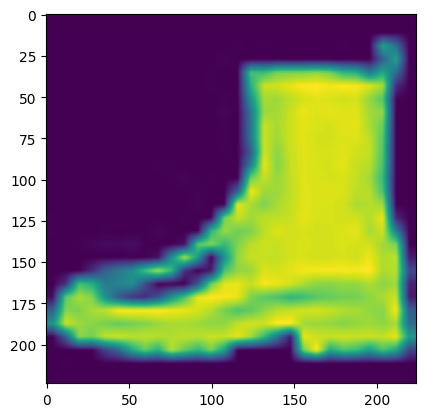

In [8]:
#Test the image resizing feature of get_data_loaders()
train_iter, val_iter = get_data_loaders(64)
for img, label in train_iter:
    print(img.shape, img.dtype, label.shape, label.dtype)
    plt.imshow(img[0,0,:,:].reshape([224,-1]))
    break

## Training

In [9]:
def train(model, train_loader, val_loader, num_epochs=1):

    """
    For num_epochs of times, iterate over the mini-batches and
    and update the parameters at each iteration.
    Record the training loss, and validation error, and plot each over iterations.
    At the start of each epoch the data is shuffled and a new set of
    mini-batches is created.

    Parameters:

        model: the neural net
        batch_size (int): mini-batch size of training and validation sets
        num_epochs(int): number of epochs to train

    Returns:

        None
    """

    # train_loader, val_loader = get_data_loaders(batch_size)

    #Pick loss and optimiser to use in training
    #Inialise loss
    criterion = nn.CrossEntropyLoss()
    #Initialise optimizer
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    #Store evaluation metrics

    train_losses, val_losses = [], []

    # Training loop
    n = 0 # the number of iterations
    start_time = time.time()

    # number of observations in the samples
    train_size = len(train_loader)
    val_size = len(val_loader)

    for epoch in range(num_epochs):

        # progress bar
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=train_size)

        train_loss = 0.0
        val_loss = 0.0

        #Iterate over the mini-batches
        #for imgs, labels in iter(train_loader):
        for i, data in progress:

            #Training mode
            model.train()

            # Transfer data to device
            imgs = data[0].to(device)
            labels = data[1].to(device)

            #Forward pass: outputs logits for each image and computes the loss value
            out = model(imgs)
            loss = criterion(out, labels)
            train_loss += loss.item() # record sum of losses over mini-batches

            #Backward pass and update
            loss.backward()               # Backprop
            optimizer.step()              # Update each parameter
            optimizer.zero_grad()         # reset gradients

            #--- Save the current training information to report-------#

            #----------Validation error-------#
            # set model to evaluating (testing)
            model.eval()

            #torch.no_grad(): Disabling gradient calculation is useful for inference, when you are sure
            #that you will not call Tensor.backward(). It will reduce memory consumption
            #for computations that would otherwise have requires_grad=True.
            with torch.no_grad():
              for imgs, labels in iter(val_loader):
                # Transfer data to device
                imgs = imgs.to(device)
                labels = labels.to(device)

                out = model(imgs)
                loss = criterion(out, labels)
                val_loss += loss.item()

        #Epoch completed
        train_losses.append(train_loss/train_size)
        val_losses.append(val_loss/val_size)

        end_time = time.time()
        print(f'Training Loss in epoch {epoch+1}/{num_epochs}: {round(train_losses[-1],5)}, Time: {round(end_time - start_time,5)}s')

    #Plotting
    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.show()

    print("Final Validation Error: {}".format(val_losses[-1]))

`get_accuracy` helper function. To turn the probabilities into a discrete prediction, we will take the digit with the highest probability. Because of the way softmax is computed, the digit with the highest probability is the same as the digit with the (pre-activation) output value.

Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 1/30: 2.30108, Time: 1.16133s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 2/30: 2.27902, Time: 1.29716s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 3/30: 2.18596, Time: 1.39842s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 4/30: 2.58162, Time: 1.51132s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 5/30: 2.20676, Time: 1.622s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 6/30: 2.24702, Time: 1.72857s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 7/30: 2.26702, Time: 1.83327s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 8/30: 2.27398, Time: 1.92738s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 9/30: 2.27459, Time: 2.02274s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 10/30: 2.27325, Time: 2.14547s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 11/30: 2.26078, Time: 2.25636s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 12/30: 2.24413, Time: 2.34088s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 13/30: 2.21605, Time: 2.42426s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 14/30: 2.17303, Time: 2.5148s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 15/30: 2.0864, Time: 2.61867s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 16/30: 2.04782, Time: 2.71288s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 17/30: 1.96564, Time: 2.80276s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 18/30: 1.87068, Time: 2.89098s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 19/30: 1.75389, Time: 2.99209s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 20/30: 1.60147, Time: 3.09812s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 21/30: 1.56225, Time: 3.20876s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 22/30: 1.38417, Time: 3.31134s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 23/30: 1.45497, Time: 3.40711s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 24/30: 1.3053, Time: 3.49714s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 25/30: 1.32802, Time: 3.59431s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 26/30: 1.23942, Time: 3.69231s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 27/30: 1.1728, Time: 3.79524s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 28/30: 1.15971, Time: 3.89376s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 29/30: 1.06565, Time: 3.98338s


Loss:   0%|          | 0/1 [00:00<?, ?it/s]

Training Loss in epoch 30/30: 0.98641, Time: 4.07958s


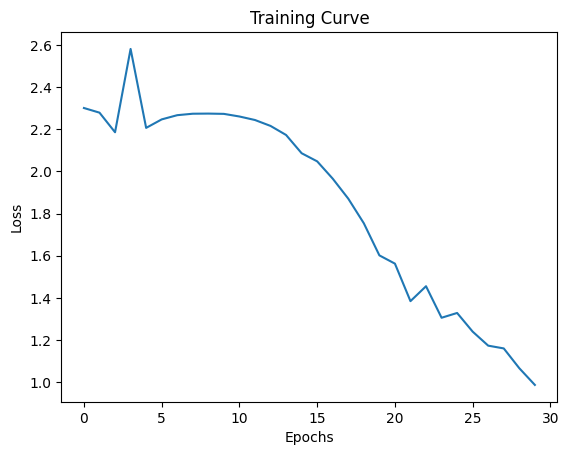

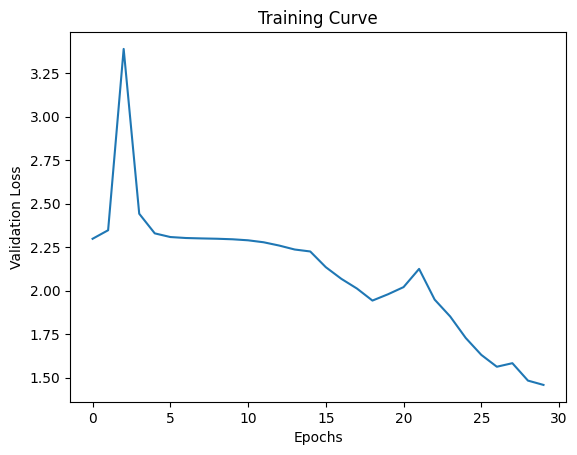

Final Validation Error: 1.4582229852676392


In [10]:
debug_train_data = next(iter(train_iter))  # Get one batch
debug_val_data = next(iter(val_iter))      # Get one batch

# Unpack the batch correctly
debug_imgs, debug_labels = debug_train_data  # Extract images and labels
debug_val_imgs, debug_val_labels = debug_val_data

# Wrap each as a Dataset object before DataLoader
from torch.utils.data import TensorDataset

debug_train_loader = DataLoader(TensorDataset(debug_imgs, debug_labels), batch_size=len(debug_imgs))
debug_val_loader = DataLoader(TensorDataset(debug_val_imgs, debug_val_labels), batch_size=len(debug_val_imgs))

train(model, debug_train_loader, debug_val_loader, num_epochs=30)


Loss:   0%|          | 0/35 [00:00<?, ?it/s]

Training Loss in epoch 1/6: 1.44497, Time: 22.16618s


Loss:   0%|          | 0/35 [00:00<?, ?it/s]

Training Loss in epoch 2/6: 0.90861, Time: 42.60242s


Loss:   0%|          | 0/35 [00:00<?, ?it/s]

Training Loss in epoch 3/6: 0.71147, Time: 62.96577s


Loss:   0%|          | 0/35 [00:00<?, ?it/s]

Training Loss in epoch 4/6: 0.59289, Time: 83.53039s


Loss:   0%|          | 0/35 [00:00<?, ?it/s]

Training Loss in epoch 5/6: 0.57799, Time: 103.77653s


Loss:   0%|          | 0/35 [00:00<?, ?it/s]

Training Loss in epoch 6/6: 0.50521, Time: 123.8936s


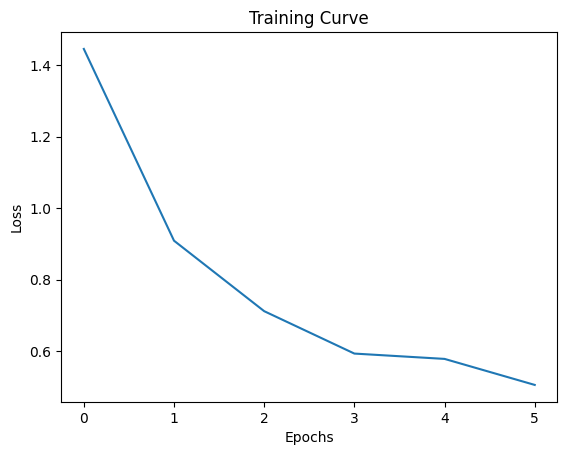

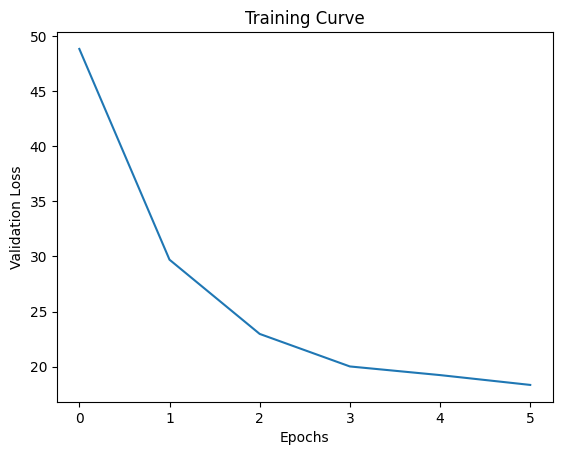

Final Validation Error: 18.346127863725027


In [11]:
train(model, train_iter, val_iter, num_epochs=6)

##**Test the model**

Once the model has been decided, you can get an estimate of the test error.
You can use the test data once only, that is, it is a mistake to go back to the training data to get a model that gives a smaller error on the test set.

Here's a blog that shows you how you can do this:

[Fashion MNIST dataset training using PyTorch](https://medium.com/@aaysbt/fashion-mnist-data-training-using-pytorch-7f6ad71e96f4)